# Notebook for t2p evaluation

### Under development...

In [2]:
# imports
import os
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import zscore
import pandas as pd


In [3]:
# this is the directory that contains a /track2p folder that is output by running the track2p algorithm
t2p_save_path = '/Users/manonmantez/Desktop/jm038' # (change this based on your data)
plane = 'plane0' # which plane to process (the example dataset is single-plane)

In [4]:
# np.load() the match matrix (plane0_match_mat.npy)
t2p_match_mat = np.load(os.path.join(t2p_save_path, 'track2p', f'{plane}_match_mat.npy'), allow_pickle=True)

# np.load() settings (this contains suite2p paths etc.) (track_ops.npy)
track_ops_dict = np.load(os.path.join(t2p_save_path, 'track2p', 'track_ops.npy'), allow_pickle=True).item()
track_ops = SimpleNamespace(**track_ops_dict) # create dummy object from the track_ops dictionary

In [5]:
print('Datasets used for t2p:\n')
for ds_path in track_ops.all_ds_path:
    print(ds_path)

Datasets used for t2p:

/Users/manonmantez/Desktop/jm038/2023-04-30_a
/Users/manonmantez/Desktop/jm038/2023-05-01_a
/Users/manonmantez/Desktop/jm038/2023-05-02_a
/Users/manonmantez/Desktop/jm038/2023-05-03_a
/Users/manonmantez/Desktop/jm038/2023-05-04_a
/Users/manonmantez/Desktop/jm038/2023-05-05_a
/Users/manonmantez/Desktop/jm038/2023-05-06_a


### Above is the output of the algorithm, now generate ground truth 

In [6]:
# load the suite2p output of the first dataset
s2p_path = os.path.join(track_ops.all_ds_path[0], 'suite2p', plane)

# load the ops and stat
ops_first = np.load(os.path.join(s2p_path, 'ops.npy'), allow_pickle=True).item()
stat_first = np.load(os.path.join(s2p_path, 'stat.npy'), allow_pickle=True)
iscell_first = np.load(os.path.join(s2p_path, 'iscell.npy'), allow_pickle=True)
s2p_inds = np.arange(len(stat_first))


# filter stat based on the track2p probability
print(f'Filtering stat based on the track2p probability (iscell_thr={track_ops.iscell_thr})')
s2p_inds_iscell = s2p_inds[iscell_first[:, 0] > track_ops.iscell_thr]
stat_first_iscell = stat_first[iscell_first[:, 0] > track_ops.iscell_thr]
print(f'Filtered stat from {len(stat_first)} to {len(stat_first_iscell)} cells')

Filtering stat based on the track2p probability (iscell_thr=0.5)
Filtered stat from 3587 to 2190 cells


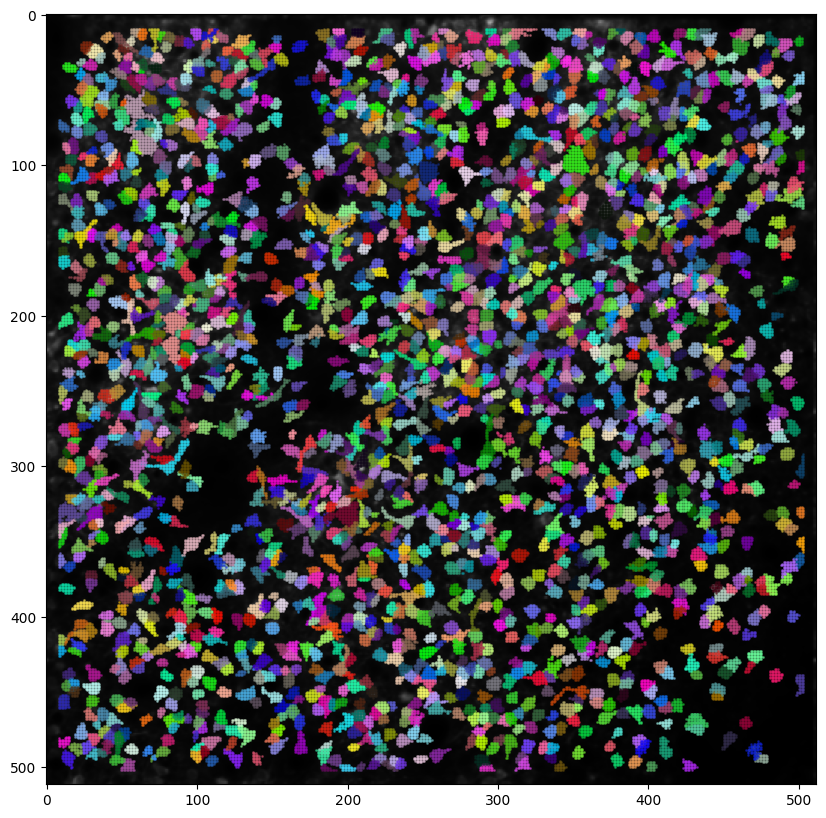

In [7]:
# now plot the fov with contours
plt.figure(figsize=(10, 10))
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(len(stat_first_iscell)):
    # get random color 
    color = np.random.rand(3)
    plt.scatter(stat_first_iscell[i]['xpix'], stat_first_iscell[i]['ypix'], s=1, color=color, alpha=0.5)

(-0.5, 511.5, 511.5, -0.5)

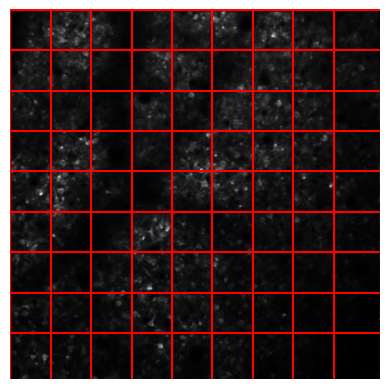

In [8]:
# now make a 8x8 grid on the image
n_grid = 9
grid_x = np.arange(0, ops_first['meanImg'].shape[1], ops_first['meanImg'].shape[1] // n_grid)
grid_y = np.arange(0, ops_first['meanImg'].shape[0], ops_first['meanImg'].shape[0] // n_grid)

plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='r')
    plt.axhline(grid_y[i], color='r')

plt.axis('off')

In [9]:
# now for each grid cross get the nearest cell (except for 0 and 512 pixels)
all_cell_med = []

# get all cell medians from stat
for i in range(len(stat_first_iscell)):
    all_cell_med.append(stat_first_iscell[i]['med'])
    


In [10]:
# compute coordinates of the grid crosses
grid_crosses = []
for i in range(1, n_grid):
    for j in range(1, n_grid):
        grid_crosses.append((grid_x[i], grid_y[j]))

In [11]:
grid_crosses

[(56, 56),
 (56, 112),
 (56, 168),
 (56, 224),
 (56, 280),
 (56, 336),
 (56, 392),
 (56, 448),
 (112, 56),
 (112, 112),
 (112, 168),
 (112, 224),
 (112, 280),
 (112, 336),
 (112, 392),
 (112, 448),
 (168, 56),
 (168, 112),
 (168, 168),
 (168, 224),
 (168, 280),
 (168, 336),
 (168, 392),
 (168, 448),
 (224, 56),
 (224, 112),
 (224, 168),
 (224, 224),
 (224, 280),
 (224, 336),
 (224, 392),
 (224, 448),
 (280, 56),
 (280, 112),
 (280, 168),
 (280, 224),
 (280, 280),
 (280, 336),
 (280, 392),
 (280, 448),
 (336, 56),
 (336, 112),
 (336, 168),
 (336, 224),
 (336, 280),
 (336, 336),
 (336, 392),
 (336, 448),
 (392, 56),
 (392, 112),
 (392, 168),
 (392, 224),
 (392, 280),
 (392, 336),
 (392, 392),
 (392, 448),
 (448, 56),
 (448, 112),
 (448, 168),
 (448, 224),
 (448, 280),
 (448, 336),
 (448, 392),
 (448, 448)]

(-0.5, 511.5, 511.5, -0.5)

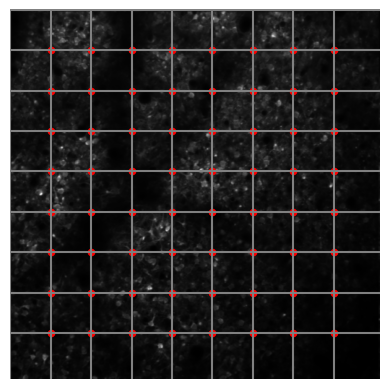

In [12]:
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='gray')
    plt.axhline(grid_y[i], color='gray')
for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='r')

plt.axis('off')


In [13]:
# compute distances between each cell and each grid cross
distances = np.zeros((len(stat_first_iscell), len(grid_crosses)))
for i, cell_med in enumerate(all_cell_med):
    for j, cross in enumerate(grid_crosses):
        distances[i, j] = np.sqrt((cell_med[0] - cross[0])**2 + (cell_med[1] - cross[1])**2)

In [14]:
# now get the nearest cell for each grid cross
nearest_cells = np.argmin(distances, axis=0)


In [15]:
nearest_cells

array([1494, 1140, 1449,  265, 1146,  924,  177, 2168, 1172,  913, 1927,
       1002, 1454,  237,  505, 1722, 1304, 1943, 1190, 1987,  429, 1490,
       2153,  364,  139, 1320, 1975,  533,  445, 1506, 1213,  880,  111,
       1217, 1520,  279, 1831, 1698,  582, 1829,  811, 1678,   79, 1293,
       1672, 1382, 1988,  980,   66, 1083,  814,   68, 1992,  856, 1679,
       1424, 1612,  984, 1258,  368,  610,  721, 1085, 2055])

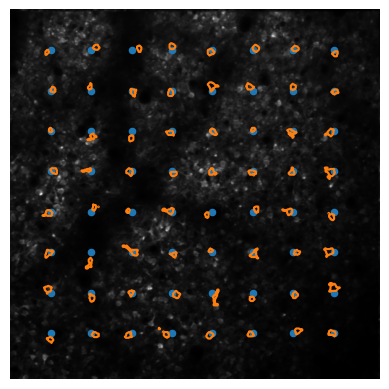

In [16]:
plt.imshow(ops_first['meanImg'], cmap='gray')

for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='C0')

plt.axis('off')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')


In [17]:
# now get the original indices
original_indices = s2p_inds_iscell[nearest_cells]
print('Now open suite2p and try to manually track cells:')
[print(f'{original_indices[i]}') for i in range(len(original_indices))]

Now open suite2p and try to manually track cells:
1779
1254
1708
267
1263
985
179
3480
1301
973
2719
1083
1717
239
511
2212
1480
2751
1326
2874
432
1773
3425
366
141
1506
2840
540
448
1796
1356
935
113
1362
1817
281
2450
2166
592
2447
853
2124
81
1464
2115
1601
2875
1059
67
1181
856
70
2881
905
2126
1672
1990
1065
1419
370
622
746
1183
3060


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

(-0.5, 511.5, 511.5, -0.5)

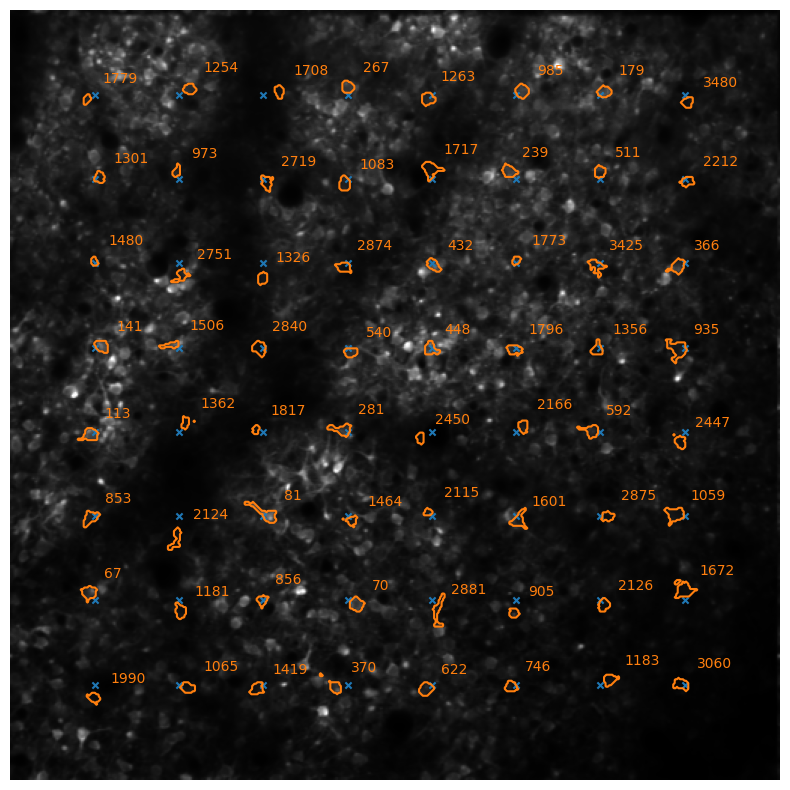

In [18]:
# make the same plot as above but with numbers labeled next to the roi
plt.figure(figsize=(10, 10))
# clip based on 99.99 percentile
img = ops_first['meanImg'].copy()
img[img > np.percentile(img, 99.99)] = np.percentile(img, 99.99)
plt.imshow(img, cmap='gray')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')
    plt.text(stat_first_iscell[cell]['med'][1]+10, stat_first_iscell[cell]['med'][0]-10, f'{original_indices[i]}', color='C1')
    plt.scatter(grid_crosses[i][0], grid_crosses[i][1], s=20, color='C0', marker='x')

plt.axis('off')


### Getting real suite2p indexes to compare it to

In [19]:

def function(path,plane):
    track_ops_dict = np.load(os.path.join(path, "track2p", "track_ops.npy"), allow_pickle=True).item()
    track_ops = SimpleNamespace(**track_ops_dict)
    t2p_match_mat = np.load(os.path.join(path,"track2p" ,f"{plane}_match_mat.npy"), allow_pickle=True)
    t2p_match_mat_allday = t2p_match_mat
    
    if track_ops.iscell_thr is not None:
        true_indices= np.empty((len(t2p_match_mat_allday), len(track_ops.all_ds_path)))
        
    for j in range(len(t2p_match_mat_allday)):
        for (i, ds_path) in enumerate(track_ops.all_ds_path):
            iscell = np.load(os.path.join(ds_path, 'suite2p', plane, 'iscell.npy'), allow_pickle=True)
            if track_ops.iscell_thr is not None:
                indices_lignes_1= np.where(iscell[:,1]>track_ops.iscell_thr)[0]
                match_index=t2p_match_mat_allday[j,i]

                if match_index is None:
                    true_index = -1
                else:
                    true_index=indices_lignes_1[match_index]

                true_indices[j, i] = true_index
            else:
                pass
    if track_ops.iscell_thr is not None:        
        np.save(os.path.join(path, "true_indices.npy"), true_indices.astype(int))
        print("saved")
    else:
        print("not in locals")
        
#Example of use
        
function(t2p_save_path,plane)

indices_npy= np.load(os.path.join(t2p_save_path,"true_indices.npy"))
#indices_npy = pd.read_csv(os.path.join(t2p_save_path, "true_indices.csv"), dtype='Int64')
print(indices_npy)
#indices_npy = indices_npy.to_numpy()

#print(indices_npy)
#print(indices_npy.dtype)
#print(indices_npy.shape)

saved
[[   0    2   36 ...  456   21  202]
 [   1   60   13 ...   14   47   55]
 [   2   16   88 ...   -1   -1   -1]
 ...
 [  -1   -1   -1 ...   -1   -1   -1]
 [3581 2320  930 ...  876  559  930]
 [  -1   -1   -1 ...   -1   -1   -1]]


In [20]:
np.sort(original_indices)

array([  67,   70,   81,  113,  141,  179,  239,  267,  281,  366,  370,
        432,  448,  511,  540,  592,  622,  746,  853,  856,  905,  935,
        973,  985, 1059, 1065, 1083, 1181, 1183, 1254, 1263, 1301, 1326,
       1356, 1362, 1419, 1464, 1480, 1506, 1601, 1672, 1708, 1717, 1773,
       1779, 1796, 1817, 1990, 2115, 2124, 2126, 2166, 2212, 2447, 2450,
       2719, 2751, 2840, 2874, 2875, 2881, 3060, 3425, 3480])

In [21]:
# index rows for cells where the first row is in original_indices
all_s2p_idxs = []
for idx in np.sort(original_indices):
    idx_row = np.where(indices_npy[:,0]==idx)
    print(idx_row)

    if len(idx_row[0]) == 0:
        s2p_idxs = [None]*len(track_ops.all_ds_path)
        print('here')
        #print(s2p_idxs)
    else:
        s2p_idxs = indices_npy[idx_row]

    all_s2p_idxs.append(s2p_idxs[0])
   # print(f's2p_indx',s2p_idxs)
   # print(s2p_idxs[0])
all_s2p_idxs = np.array(all_s2p_idxs)

#print(all_s2p_idxs.dtype)
print(all_s2p_idxs)

(array([66]),)
(array([68]),)
(array([79]),)
(array([111]),)
(array([139]),)
(array([177]),)
(array([237]),)
(array([265]),)
(array([279]),)
(array([364]),)
(array([368]),)
(array([429]),)
(array([445]),)
(array([505]),)
(array([], dtype=int64),)
here
(array([], dtype=int64),)
here
(array([610]),)
(array([721]),)
(array([], dtype=int64),)
here
(array([814]),)
(array([], dtype=int64),)
here
(array([880]),)
(array([], dtype=int64),)
here
(array([924]),)
(array([], dtype=int64),)
here
(array([984]),)
(array([1002]),)
(array([1083]),)
(array([], dtype=int64),)
here
(array([1140]),)
(array([], dtype=int64),)
here
(array([1172]),)
(array([1190]),)
(array([1213]),)
(array([1217]),)
(array([1258]),)
(array([1293]),)
(array([], dtype=int64),)
here
(array([1320]),)
(array([1382]),)
(array([1424]),)
(array([1449]),)
(array([1454]),)
(array([1490]),)
(array([1494]),)
(array([1506]),)
(array([1520]),)
(array([1612]),)
(array([1672]),)
(array([1678]),)
(array([1679]),)
(array([1698]),)
(array([1722]

/var/folders/95/8rmbkst12z960tdjyz8xj_h40000gn/T/ipykernel_60958/3105199846.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_s2p_idxs = np.array(all_s2p_idxs)


## Comparing to manual evaluation

In [22]:
manual_matches = [
    [3076, 1378, 1198, 1000, 578, 943, 1190],
    [2597, None, None, None, None, None, None],
    [282, None, None, None, None, None, None],
    [337, 910, 428, None, None, None, None],
    [383, 745, 1224, 1553, 841, 1106, 618],
    [403, 334, 617, 256, 520, 351, 753],
    [340, 241, 363, 352, 364, 121, 126],
    [245, 150, 302, 305, 292, 440, 665],
    [2749, 2579, 2267, 1754, None, None, None]
]

In [23]:
manual_matches = np.array(manual_matches)
print(manual_matches)

[[3076 1378 1198 1000 578 943 1190]
 [2597 None None None None None None]
 [282 None None None None None None]
 [337 910 428 None None None None]
 [383 745 1224 1553 841 1106 618]
 [403 334 617 256 520 351 753]
 [340 241 363 352 364 121 126]
 [245 150 302 305 292 440 665]
 [2749 2579 2267 1754 None None None]]


In [24]:
sort_indeces = np.argsort(manual_matches[:,0])
manual_matches = manual_matches[sort_indeces]


In [25]:
all_s2p_idxs

array([array([ 67,  38,  15, 169,  -1,  -1,  -1]),
       array([ 70, 193, 224, 119, 120, 199,  76]),
       array([ 81, 187,  65,  50,  21, 129,  11]),
       array([113,  67, 170,  46, 487,  32,  99]),
       array([ 141,  140,  553,  713, 1116,   10,   12]),
       array([179, 521, 823, 230,  -1,  -1,  -1]),
       array([239, 154, 417,  16,  52,  94,  30]),
       array([267, 313,  38,  -1,  -1,  -1,  -1]),
       array([281, 953, 294, 208,  26,  80,  84]),
       array([366, 118, 150,  36,  19,  26, 218]),
       array([ 370,  786, 1271,  842,  421,  472,  488]),
       array([432, 538, 370, 612, 188, 722, 510]),
       array([ 448, 3060,   -1,   -1,   -1,   -1,   -1]),
       array([511, 874, 880,  -1,  -1,  -1,  -1]), None, None,
       array([ 622,  434, 1141,  888, 1133, 1789,   -1]),
       array([ 746, 1285, 1446,   -1,   -1,   -1,   -1]), None,
       array([ 856, 1163, 1085, 1056,  441,  465,  688]), None,
       array([ 935,  547, 1244,  212,  331,  531, 1161]), None,
   

In [1]:
for i in range(len(manual_matches)):
    # print the rows
    print(f'track2p:     {all_s2p_idxs[i]}')
    print(f'manual:      {manual_matches[i]}')
    print('')

NameError: name 'manual_matches' is not defined

## Comparing to manual evaluation (Manon)

In [28]:
manual_matches = pd.read_csv(os.path.join(t2p_save_path,'evaluation_t2p.csv'), sep=';', dtype='Int64')
print(manual_matches)
nb_nan_per_row = manual_matches.isna().sum(axis=1)
print(nb_nan_per_row)

nb_days = manual_matches.shape[1]
for i in range(nb_days): 
    nb_rows_i_nan = (nb_nan_per_row == i).sum()
    indices_i_nan = nb_nan_per_row[nb_nan_per_row == i].index
    print(f"Nombre de cellules présentes sur {nb_days-i} jours : {nb_rows_i_nan}")
    print(f"Indices : {list(indices_i_nan)}")
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/manonmantez/Desktop/jm038/evaluation_t2p.csv'

In [ ]:
manual_matches.fillna(-1, inplace=True)
print(manual_matches)

In [ ]:
manual_matches = manual_matches.to_numpy()
sort_indeces = np.argsort(manual_matches[:,0])
manual_matches = manual_matches[sort_indeces]
print(manual_matches)

In [ ]:
count= 0 
indices_good_matches= []
indices_mismatches= []
indices_cells_not_found= []

for i in range(len(manual_matches)):
    print(i)
    track2p_array = np.array(all_s2p_idxs[i])
    print(f'track2p: {track2p_array}')
    manual_array = np.array(manual_matches[i])
    print(f'manual:      {manual_array}')
    if all_s2p_idxs[i] is None and np.count_nonzero(manual_array == -1) == 6:
        print("good (not found)")
        count += 1
        indices_good_matches.append(i)
        indices_cells_not_found.append(i)
    elif np.array_equal(track2p_array, manual_array):
        print("good")
        count += 1
        indices_good_matches.append(i)
    else:
        count += 1
        print("mismatch")
        indices_mismatches.append(i)
    print('')

    
print(f'Number of cells for which manual annotation and track2p results are identical : {count} of {len(manual_matches)}')
print(f'Good {indices_good_matches}')
print(f'Bad {indices_mismatches}')
print(f'Not found {indices_cells_not_found}')
print(len(indices_good_matches))
print(len(indices_cells_not_found))


NameError: name 'manual_matches' is not defined

In [ ]:
track2p_array = np.array(all_s2p_idxs[14])
print(track2p_array)


In [ ]:
import os
import numpy as np
import matplotlib.colors as mcolors
import random
from types import SimpleNamespace

t2p_save_path = '/Users/manonmantez/Desktop/jm038/' # (change this based on your data)
plane = 'plane0' # which plane to process (the example dataset is single-plane)
t2p_match_mat = np.load(os.path.join(t2p_save_path,"track2p" ,f"{plane}_match_mat.npy"), allow_pickle=True)
track_ops_dict = np.load(os.path.join(t2p_save_path, "track2p", "track_ops.npy"), allow_pickle=True).item()
track_ops = SimpleNamespace(**track_ops_dict)

all_iscell=[]
      
for (i, ds_path) in enumerate(track_ops.all_ds_path):
            ops = np.load(os.path.join(ds_path, 'suite2p', f'{plane}', 'ops.npy'), allow_pickle=True).item()
            stat = np.load(os.path.join(ds_path, 'suite2p', f'{plane}', 'stat.npy'), allow_pickle=True)
            f = np.load(os.path.join(ds_path, 'suite2p', f'{plane}', 'F.npy'), allow_pickle=True)
            iscell = np.load(os.path.join(ds_path, 'suite2p', f'{plane}', 'iscell.npy'), allow_pickle=True)
         
            all_iscell.append(iscell)
            
for bad_indices in indices_mismatches:
    print(f'cell: {bad_indices}')
    line_manual= manual_matches[bad_indices]
    line_track2p= all_s2p_idxs[bad_indices]
    print(f'manual :{line_manual}')
    print(f'track2p: {line_track2p}')
    for i in range(len(line_manual)):
        print(f'manual indice jour {i + 1} : {line_manual[i]}')
        print(f' iscell prob {all_iscell[i][line_manual[i]]}')
        if line_track2p is not None:
            print(f'track2p indice jour {i + 1} : {line_track2p[i]}')
            print(f' iscell prob {all_iscell[i][line_track2p[i]]}')
        else :
            print(line_track2p)
            

            
